# Pierre's modelization notebook

## Import of modules

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

## Analysis of features and target

#### Opening of the DataFrame

In [22]:
# Convert the preprocessed data csv into a pandas DataFrame
dfInit = pd.read_csv('../../data/preprocessed_data_2.csv')

# Show the 5 first lines of the dataframe
dfInit.head()

,C concentration (weight%),Si concentration (weight%),Mn concentration (weight%),S concentration (weight%),P concentration (weight%),Ni concentration (weight%),Cr concentration (weight%),Mo concentration (weight%),V concentration (weight%),Cu concentration (weight%),...,Heat input (kJ/mm),Interpass temperature (deg C),Post weld heat treatment temperature (deg C),Post weld heat treatment time (hours),Yield strength (MPa),Ultimate tensile strength (MPa),Elongation (%),Reduction of Area (%),Charpy temperature (deg C),Charpy impact toughness (J)
0,-0.185820,-0.380275,0.648753,-0.278147,-0.026682,-0.312118,-0.438606,-0.58048,-0.487445,-0.303484,...,-0.603633,-0.036079,-0.030223,1.812757,-0.742112,-0.706432,0.661857,0.661801,NaN,NaN
1,-0.185820,-0.380275,0.648753,-0.278147,-0.026682,-0.312118,-0.438606,-0.58048,-0.487445,-0.303484,...,-0.603633,-0.036079,-0.873455,-0.716089,NaN,NaN,NaN,NaN,-0.219167,-1.172515
2,-0.185820,-0.380275,0.648753,-0.278147,-0.026682,-0.312118,-0.438606,-0.58048,-0.487445,-0.303484,...,-0.603633,-0.036079,-0.873455,-0.716089,NaN,NaN,NaN,NaN,0.397754,0.379770
3,-0.185820,-0.380275,0.648753,-0.278147,-0.026682,-0.312118,-0.438606,-0.58048,-0.487445,-0.303484,...,-0.603633,-0.036079,-0.873455,-0.716089,NaN,NaN,NaN,NaN,NaN,NaN
4,0.153081,-0.380275,0.471326,-0.278147,-0.026682,-0.312118,-0.438606,-0.58048,-0.487445,-0.303484,...,-0.603633,-0.036079,-0.030223,1.812757,-0.604613,-0.540476,0.235831,0.125532,NaN,NaN


#### Deletion of the useless columns for the prediction and determination of the best target columns

We have various steel, yet the charpy temperature seems to have huge differences depending of the type.

In [3]:
# Store the 'Charpy temperature (deg C)' column in another variable
charpyTemperature = dfInit['Charpy temperature (deg C)']

# Drop the 'Charpy temperature (deg C)' column
df = dfInit.drop('Charpy temperature (deg C)',axis=1)

# Get the name of the target columns 
testNames = ['Yield strength (MPa)','Ultimate tensile strength (MPa)', 'Elongation (%)',
            'Reduction of Area (%)','Charpy impact toughness (J)']

# Get the name of the feature columns
featureNames = df.columns.difference(testNames)

### Information printing
This part is based on Clarisse's work.

This part will be usefull to decide how the target will be created with the columns referring to the welding test quality (Can be called "test columns").

We start with a Boolean columns creation : see for each row if the test is done.

In [4]:
# Initialize the dataframe that will contain the new columns
dfAugmented = df.copy()

# Initialize the list which will contain the name of the new columns
newColNames=['nb']

# Create a column that will tell how many test each observation has
# Initialize all the values to 0
dfAugmented['nb'] = 0

# Create a column, composed of boolean, with the suffix "_test" for each test column
# to see if the test is done or not (blank cells or not) and a column that will tell
# how many test each observation has
for c in testNames:
    n=c+'_test'
    dfAugmented[n] = np.where(dfAugmented[c].isna(),0,1)
    newColNames.append(n)
    dfAugmented['nb'] = dfAugmented['nb'] + dfAugmented[n]

In [5]:
# Display of test completion rate
for k in newColNames[1:]:
    dfInter = dfAugmented[k].value_counts().reset_index()
    dfInter['count'] = (dfInter['count']*100)/dfInter['count'].sum()
    print(k,'\nTest not done',int(dfInter['count'].to_list()[0]), '%\nTest done',int(dfInter['count'].to_list()[1]),'%\n')

# Display the number of tests performed on each observation
dfAugmented['nb'].value_counts()

Yield strength (MPa)_test 
Test not done 55 %
Test done 44 %

Ultimate tensile strength (MPa)_test 
Test not done 57 %
Test done 42 %

Elongation (%)_test 
Test not done 62 %
Test done 37 %

Reduction of Area (%)_test 
Test not done 61 %
Test done 38 %

Charpy impact toughness (J)_test 
Test not done 54 %
Test done 45 %



nb
1    512
4    283
5     89
0     83
2     26
3     17
Name: count, dtype: int64

Conclusion : 

Nearly half of the instances have only one test. All tests are done approximately 50% of the time. There are only 82 instances out of 1652 which do not have any tests.

### Preparation of the columns that are use to create the target 

Limit values have been obtained from ChatGPT to establish if a welding is good.

The first part of the work is to get the threshold and to normalize them based on the data "welddb.data".

The final dataset for the model will be created with a column called "y" which will be composed of a bool for each instance (1 if the welding is good, 0 otherwise) and the other columns of df without the columns about the tests. 

In [6]:
# Reading the data file with space-separated values and no headers
data = pd.read_table("../../data/welddb.data", sep=" ", header=None)

# Replacing all occurrences of 'N' with None to handle missing values
data.replace('N', None, inplace=True)

# Assigning column names to the dataset
data.columns = ["C concentration (weight%)", "Si concentration (weight%)", "Mn concentration (weight%)", 
                "S concentration (weight%)", "P concentration (weight%)", "Ni concentration (weight%)", 
                "Cr concentration (weight%)", "Mo concentration (weight%)", "V concentration (weight%)", 
                "Cu concentration (weight%)", "Co concentration (weight%)", "W concentration (weight%)", 
                "O concentration (ppm/weight)", "Ti concentration (ppm/weight)", "N concentration (ppm/weight)", 
                "Al concentration (ppm/weight)", "B concentration (ppm/weight)", "Nb concentration (ppm/weight)", 
                "Sn concentration (ppm/weight)", "As concentration (ppm/weight)", "Sb concentration (ppm/weight)", 
                "Current (A)", "Voltage (V)", "AC or DC", "Electrode positive or negative", 
                "Heat input (kJ/mm)", "Interpass temperature (deg C)", "Type of weld", 
                "Post weld heat treatment temperature (deg C)", "Post weld heat treatment time (hours)", 
                "Yield strength (MPa)", "Ultimate tensile strength (MPa)", "Elongation (%)", 
                "Reduction of Area (%)", "Charpy temperature (deg C)", "Charpy impact toughness (J)", 
                "Hardness (kg/mm2)", "50 FATT", "Primary ferrite in microstructure (%)", 
                "Ferrite with second phase (%)", "Acicular ferrite (%)", "Martensite(%)", 
                "Ferrite with carbide aggregate (%)", "Weld ID"]

# Removing '<' symbols from the data using regex replacement
data = data.replace("<", "", regex=True)

# Cleaning up the 'N concentration (ppm/weight)' column by splitting on 'tot' and keeping only the first part
data['N concentration (ppm/weight)'] = data['N concentration (ppm/weight)'].str.split("tot").str[0]

# Cleaning the 'Hardness (kg/mm2)' column by removing anything after '(' or 'H'
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("(").str[0]
data['Hardness (kg/mm2)'] = data['Hardness (kg/mm2)'].str.split("H").str[0]

# Replacing the temperature range '150-200' with its average value '175'
data['Interpass temperature (deg C)'] = data['Interpass temperature (deg C)'].replace('150-200', '175')

# Converting all columns to float type, except columns with indices 23, 24, 27, and 43
for i, column in enumerate(data.columns):
    if i not in [23, 24, 27, 43]:
        data[column] = data[column].astype(float)

# Converting column names to strings (in case they were not already strings)
data.columns = data.columns.map(str)

# Selecting only a subset of columns, stored in 'col_test' (which is assumed to be predefined elsewhere)
data = data[testNames]

# Calculating the mean of each column in the selected subset
means = data.mean()

# Calculating the standard deviation of each column in the selected subset
stds = data.std()


# Init a dictionnary thresholds
thresholds = {
    'Yield strength (MPa)' : {350:[]},
    'Ultimate tensile strength (MPa)' : {500:[]},
    'Elongation (%)': {20:[]},
    'Reduction of Area (%)':{20:[]},
    'Charpy impact toughness (J)':{50:[]}
}

# Normalize thresholds
for c in testNames:
    val = list(thresholds[c].keys())[0]
    thresholds[c] = (val - means[c]) / stds[c]

### Prediction

The prediction will be done with a random forest regressor.

Method for the prediction :

- Hyperparameter grid setup 
- Loop over each five test 
- Remove rows with missing target values 
- Feature and target matrix creation 
- Train-test split 
- GridSearchCV setup and training 
- Best model selection 
- Model evaluation using MSE 
- Predict missing values 

In [7]:
# Define the hyperparameter grid to search
paramGrid = {
    'n_estimators': [20, 50, 100, 200, 500],         # Number of trees in the forest
    'max_depth': [None, 10, 15, 20, 50],             # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                 # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 8, 12, 20],        # Minimum number of samples required to be at a leaf node
}

dfFinal = dfAugmented.copy()

# Dictionary to store the best model for each test
best_models = {}

# Loop over each test to train a RandomForestRegressor with Grid Search and fill missing values
for test in testNames:
    print(f"\nProcessing for test: {test}")
    
    # Create dataset for the current test, removing rows where the target value is NaN
    dfTest = dfAugmented.dropna(subset=[test], inplace=False)

    # Check if the current test is 'Charpy impact toughness (J)'
    if test == 'Charpy impact toughness (J)':
        dfTest['Charpy temperature (deg C)'] = charpyTemperature.loc[dfTest.index]

    # Create feature matrix Xi and target vector yi
    columnsToRemove = testNames + [col for col in dfTest.columns if col.endswith('_test')] + ['nb']
    Xi = dfTest.drop(columns=columnsToRemove, inplace=False)
    yi = dfTest[test]

    # Split data into training and test sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(Xi, yi, test_size=0.2, random_state=0)

    # Setup GridSearchCV
    rf = RandomForestRegressor(random_state=0)
    
    # Initialize the GridSearchCV with cross-validation
    gridSearch = GridSearchCV(estimator=rf, param_grid=paramGrid, 
                               cv=5, scoring='neg_mean_squared_error', 
                               verbose=1, n_jobs=4)
    
    # Train the best model found by Grid Search
    gridSearch.fit(X_train, y_train)
    
    best_model = gridSearch.best_estimator_
    best_models[test] = best_model  # Store the best model for this test
    print(f"Best parameters for {test}: {gridSearch.best_params_}")
    
    # **Evaluate the model using MSE on the test set**
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE for {test} on test set: {mse:.4f}")
    
    # Predict missing values in the original dataset (dfAugmented)
    missing_idx = dfAugmented[dfAugmented[test].isna()].index
    Xi_missing = dfAugmented.loc[missing_idx].drop(columns=columnsToRemove, inplace=False)
    if test == 'Charpy impact toughness (J)':
        Xi_missing['Charpy temperature (deg C)'] = charpyTemperature.loc[dfTest.index]
    
    if len(Xi_missing) > 0:
        predicted_values = best_model.predict(Xi_missing)
        dfFinal.loc[missing_idx, test] = predicted_values
        print(f"Predicted missing values for {test}: {len(missing_idx)} rows filled.")
    else:
        print(f"No missing values to predict for {test}.")





Processing for test: Yield strength (MPa)
Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best parameters for Yield strength (MPa): {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
MSE for Yield strength (MPa) on test set: 0.1840
Predicted missing values for Yield strength (MPa): 564 rows filled.

Processing for test: Ultimate tensile strength (MPa)
Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best parameters for Ultimate tensile strength (MPa): {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
MSE for Ultimate tensile strength (MPa) on test set: 0.0727
Predicted missing values for Ultimate tensile strength (MPa): 580 rows filled.

Processing for test: Elongation (%)
Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Best parameters for Elongation (%): {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
MSE for Elongation (%) on test

C:\Users\pierr\AppData\Local\Temp\ipykernel_23044\3856917474.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTest['Charpy temperature (deg C)'] = charpyTemperature.loc[dfTest.index]


Best parameters for Charpy impact toughness (J): {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MSE for Charpy impact toughness (J) on test set: 0.1841
Predicted missing values for Charpy impact toughness (J): 462 rows filled.



Plotting regression results for test: Yield strength (MPa)


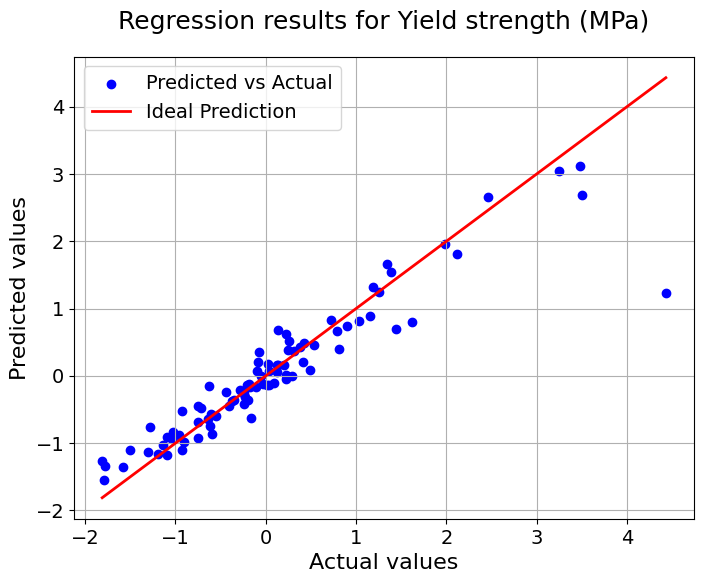


Plotting regression results for test: Ultimate tensile strength (MPa)


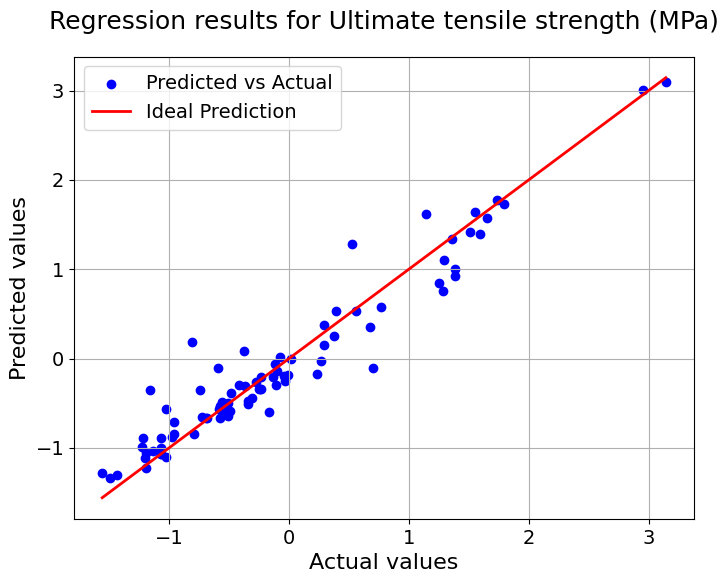


Plotting regression results for test: Elongation (%)


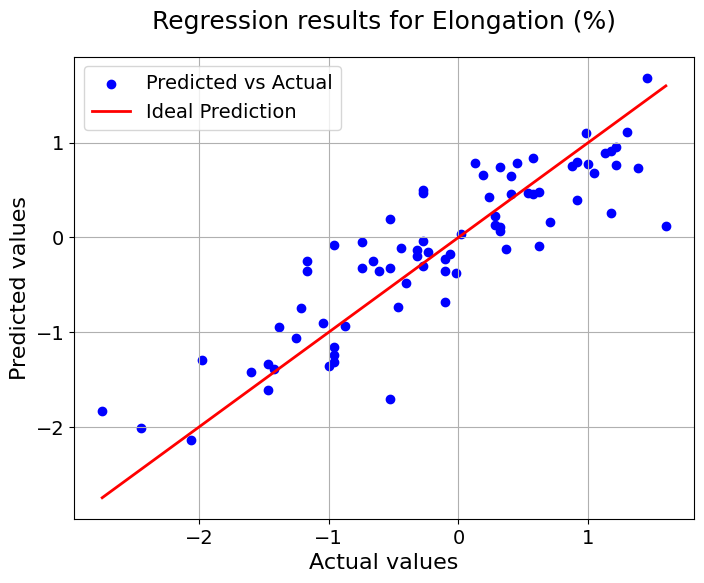


Plotting regression results for test: Reduction of Area (%)


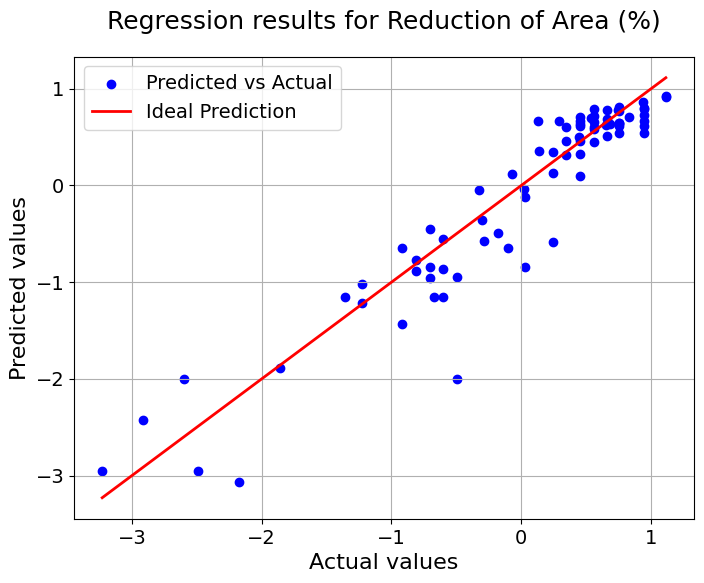


Plotting regression results for test: Charpy impact toughness (J)


C:\Users\pierr\AppData\Local\Temp\ipykernel_23044\2489612009.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTest['Charpy temperature (deg C)'] = charpyTemperature.loc[dfTest.index]


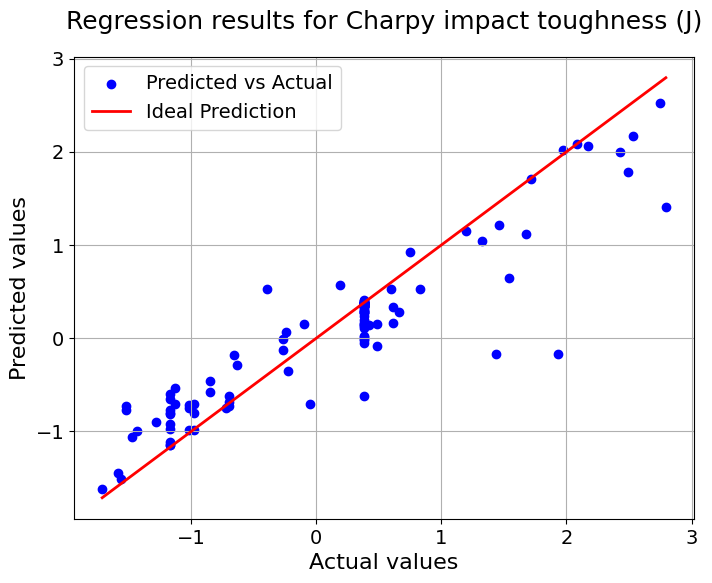

In [8]:
# Loop over each test to plot the regression results using the respective best RandomForest model
for test in testNames:
    print(f"\nPlotting regression results for test: {test}")
    
    # Create dataset for the current test, removing rows where the target value is NaN
    dfTest = dfAugmented.dropna(subset=[test], inplace=False)
    
    if test == 'Charpy impact toughness (J)':
        dfTest['Charpy temperature (deg C)'] = charpyTemperature.loc[dfTest.index]

    # Create feature matrix Xi and target vector yi
    columnsToRemove = testNames + [col for col in dfTest.columns if col.endswith('_test')] + ['nb']
    Xi = dfTest.drop(columns=columnsToRemove, inplace=False)
    yi = dfTest[test]

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(Xi, yi, test_size=0.2, random_state=0)

    # Retrieve the best model for this test
    best_model = best_models[test]

    # Predict the values on the test set with the best model
    y_pred = best_model.predict(X_test)
    
    # Plot predicted values vs actual values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Prediction')
    plt.title(f"Regression results for {test}", fontsize=18, pad=20)
    plt.xlabel('Actual values', fontsize=16)
    plt.ylabel('Predicted values', fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    
    # Show plot
    plt.show()

In [9]:
# We check if all test values are above their respective thresholds to decide if the weld is "Good" (1) or "Not Good" (0)
dfFinal['weld_quality'] = 1  # Initialize all to "Good" (1)

for test in testNames:
    threshold_value = thresholds[test]
    dfFinal['weld_quality'] = np.where(dfFinal[test] >= threshold_value, dfFinal['weld_quality'], 0)

# Output a summary of the weld quality
good_welds = (dfFinal['weld_quality'] == 1).sum()
bad_welds = (dfFinal['weld_quality'] == 0).sum()

print(f"Final count of good welds: {good_welds}")
print(f"Final count of bad welds: {bad_welds}")


Final count of good welds: 628
Final count of bad welds: 382


### Trying PCA + Random Forest

In [18]:
# Drop boolean features  
dfPCA = df.drop(columns=df.select_dtypes(include=['bool']).columns)

#We dont want to apply the pca on the target
dfPCAx = dfPCA.drop(columns= testNames + [col for col in df.columns if col.endswith('_test')],axis=1)

In [11]:
pca = PCA()
pca.fit(dfPCAx)

print('Variance for each pca axis :')
print(pca.explained_variance_ratio_ * 100)
print('(i elt = variance for th i axis )')

Variance for each pca axis :
[20.53955465 12.64184742 10.42834915  7.89428066  6.04548537  5.54466844
  4.67901259  4.06372099  3.56725036  3.16468352  3.12006435  3.08585223
  2.58745613  2.06757526  2.03238512  1.66083618  1.42382185  1.24372809
  1.12562256  0.91471224  0.79655372  0.42472448  0.27178289  0.22762304
  0.20880961  0.18102285  0.05857626]
(i elt = variance for th i axis )


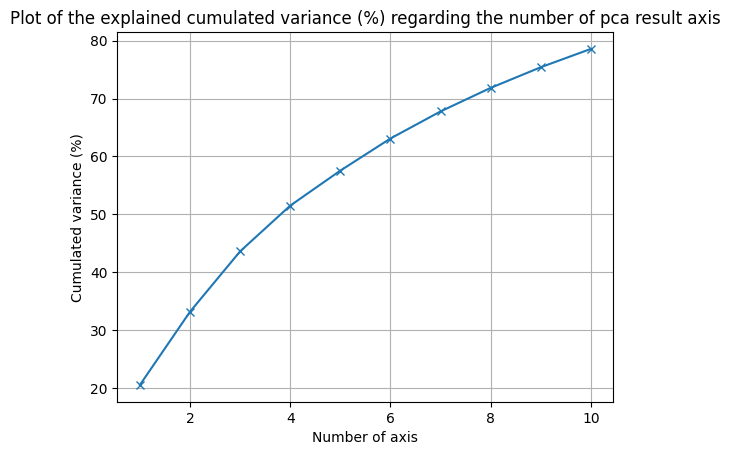

In [19]:
# cumulated variance
varcum = pca.explained_variance_ratio_.cumsum()

# Cumulated variance plot 
plt.plot(range(1, len(varcum) + 1), varcum * 100, marker='x')
plt.xlabel('Number of axis')
plt.ylabel('Cumulated variance (%)')
#plt.title('Graphique de la variance cumulée expliquée selon le nombre de composantes principales')
plt.title('Plot of the explained cumulated variance (%) regarding the number of pca result axis')
plt.grid(True)
plt.show()

In [20]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(dfPCAx)

var_tot = sum(pca.explained_variance_ratio_) * 100
print("Total variance :",var_tot,'%')

Total variance : 78.56885313816295 %


### Apply the Random Forest Regressor on the new Dataset

In [16]:
# Define the hyperparameter grid to search
paramGrid = {
    # 'n_estimators': [20, 50, 100, 200, 500],         # Number of trees in the forest
    'max_depth': [None, 10, 15, 20, 50],             # Maximum depth of the tree
    # 'min_samples_split': [2, 5, 10],                 # Minimum number of samples required to split an internal node
    # 'min_samples_leaf': [1, 2, 4, 8, 12, 20],        # Minimum number of samples required to be at a leaf node
}


# Dictionary to store the best model for each test
best_models = {}
Xpca = pd.DataFrame(X_pca)

# Loop over each test to train a RandomForestRegressor with Grid Search and fill missing values
for test in testNames:
    print(f"\nProcessing for test: {test}")
    
    # Use Xpca as feature matrix and ypca as the target vector
    Xpca_test = Xpca.copy()
    ypca = dfAugmented[test]  # Assuming `ypca` corresponds to the target column for the test

    # Remove rows where the target value (ypca) is NaN
    # Here, filter both Xpca and ypca based on non-NaN values in ypca
    non_nan_indices = ypca.dropna().index
    Xpca_test = Xpca.loc[non_nan_indices]
    ypca = ypca.loc[non_nan_indices]

    # Split the data into training and test sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(Xpca_test, ypca, test_size=0.2, random_state=0)

    # Setup GridSearchCV with RandomForestRegressor
    rf = RandomForestRegressor(random_state=0)
    
    # Initialize the GridSearchCV with cross-validation
    gridSearch = GridSearchCV(estimator=rf, param_grid=paramGrid, 
                               cv=5, scoring='neg_mean_squared_error', 
                               verbose=1, n_jobs=4)
    
    # Train the best model found by Grid Search
    gridSearch.fit(X_train, y_train)
    
    best_model = gridSearch.best_estimator_
    best_models[test] = best_model  # Store the best model for this test
    print(f"Best parameters for {test}: {gridSearch.best_params_}")
    
    # **Evaluate the model using MSE on the test set**
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE for {test} on test set: {mse:.4f}")
    
    # Predict missing values in the original dataset (dfAugmented)
    missing_idx = dfAugmented[dfAugmented[test].isna()].index
    Xi_missing = Xpca.loc[missing_idx]  # Use Xpca for the missing data
    
    if test == 'Charpy impact toughness (J)':
        Xi_missing['Charpy temperature (deg C)'] = charpyTemperature.loc[missing_idx]  # Adjust as necessary



Processing for test: Yield strength (MPa)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Yield strength (MPa): {'max_depth': 15}
MSE for Yield strength (MPa) on test set: 0.2195

Processing for test: Ultimate tensile strength (MPa)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Ultimate tensile strength (MPa): {'max_depth': 10}
MSE for Ultimate tensile strength (MPa) on test set: 0.1210

Processing for test: Elongation (%)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Elongation (%): {'max_depth': 15}
MSE for Elongation (%) on test set: 0.2386

Processing for test: Reduction of Area (%)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Reduction of Area (%): {'max_depth': 15}
MSE for Reduction of Area (%) on test set: 0.0949

Processing for test: Charpy impact toughness (J)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters for Char

## Conclusion

The PCA permits to have similar results 